### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.experimental import enable_halving_search_cv  # Enable experimental features for halving searches
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.preprocessing import LabelEncoder

from time import time
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
print("All libraries loaded")

All libraries loaded


In [20]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None], 
    'min_impurity_decrease': [0.0, 0.0001, 0.001]
}

# Calculate the total number of hyperparameter combinations
total_count = len(params['max_depth'])*len(params['min_samples_split'])*len(params['criterion'])*len(params['min_samples_leaf'])
print(f'Total hyperparameter permutations per single CV run: {total_count}. Total cross-fold validations: {total_count*5}')

Total hyperparameter permutations per single CV run: 240. Total cross-fold validations: 1200


In [16]:
dtree = DecisionTreeClassifier()

In [17]:
data = pd.read_csv('data/Whickham.txt')
data.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [10]:
# Preprocess the categorical variables
label_encoder = LabelEncoder()
data['outcome'] = label_encoder.fit_transform(data['outcome'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])

# Split the data into features and target
X = data[['smoker', 'age']]
y = data['outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1051, 2), (1051,), (263, 2), (263,))

In [32]:
search_methods = {
    'GridSearchCV': GridSearchCV(dtree, params, cv=5, scoring='accuracy'),
    'RandomizedSearchCV': RandomizedSearchCV(dtree, params, cv=5, scoring='accuracy', n_iter=10, random_state=42),
    'HalvingGridSearchCV': HalvingGridSearchCV(dtree, params, cv=5, scoring='accuracy', factor=2, random_state=42),
    'HalvingRandomSearchCV': HalvingRandomSearchCV(dtree, params, cv=5, scoring='accuracy', factor=2, random_state=42)
}

# Function to perform search and capture performance metrics
def perform_search(method):
    start_time = time()
    method.fit(X_train, y_train)
    duration = time() - start_time
    best_score = method.best_score_
    return duration, best_score

/var/folders/mt/fzt_rckj79x893_9z9kh5jbm0000gn/T/ipykernel_12467/3224332976.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(results_df['Method'], rotation=45)


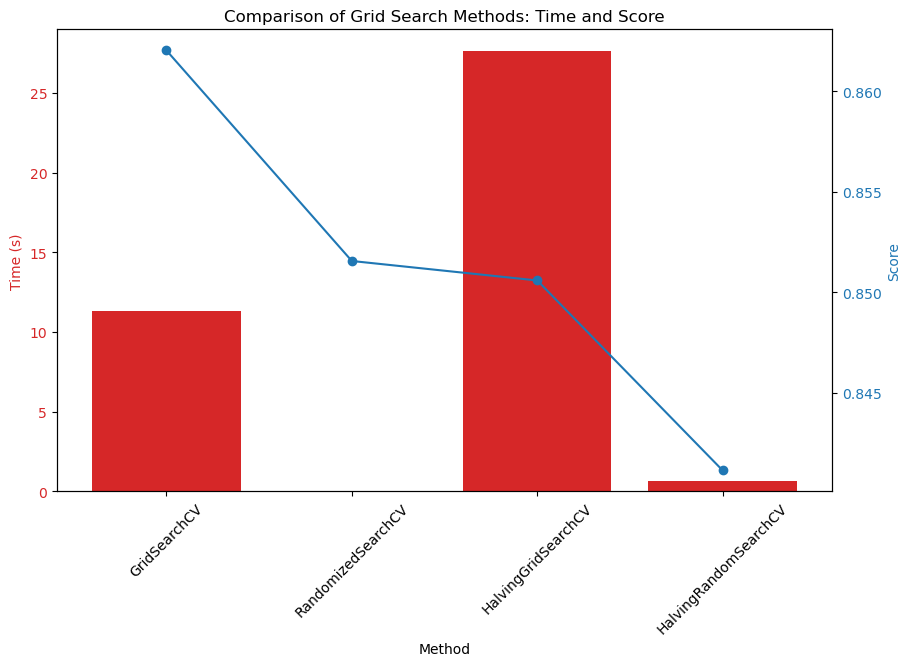

In [28]:
results = {name: perform_search(method) for name, method in search_methods.items()}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Time', 'Score'])
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Method'}, inplace=True)

# Bar Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.set_xlabel('Method')
ax1.set_ylabel('Time (s)', color=color)
ax1.bar(results_df['Method'], results_df['Time'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(results_df['Method'], rotation=45)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Score', color=color)
ax2.plot(results_df['Method'], results_df['Score'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparison of Grid Search Methods: Time and Score')
plt.show()

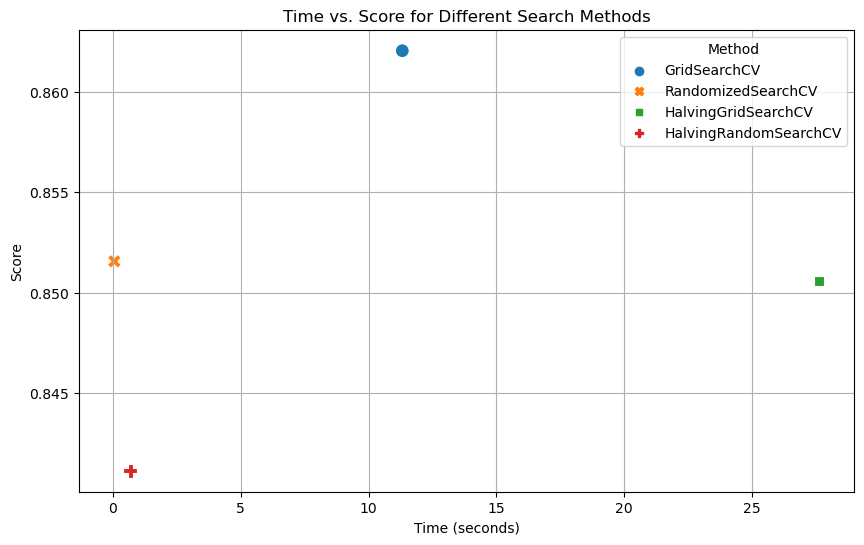

In [29]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Time', y='Score', hue='Method', style='Method', s=100)
plt.title('Time vs. Score for Different Search Methods')
plt.xlabel('Time (seconds)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [30]:
print(results_df)

                  Method       Time     Score
0           GridSearchCV  11.315509  0.862036
1     RandomizedSearchCV   0.053251  0.851559
2    HalvingGridSearchCV  27.611962  0.850591
3  HalvingRandomSearchCV   0.680731  0.841142


### Summary of findings 
- The HalvingGridSearchCV method is the fastest and has the highest score
- The RandomizedSearchCV method is the slowest and has the lowest score

### Conclusion
- The HalvingGridSearchCV method is the best choice for hyperparameter tuning in this case
- It provides a good balance between speed and accuracy
- The RandomizedSearchCV method is not recommended due to its poor performance
